<a href="https://colab.research.google.com/github/AlyW8/Data-Science/blob/main/Unit5ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

# Unit 5 Exercises: Leverage + Practice with GLMs

In these exercises, we'll focus on:
- how to recognize high leverage values, and what to do about them.
- how to decide when a generalized linear model is better than than an all normal, straight line model

We'll start  by looking at the full NBA data set from class, and interogate why I removed so many observations from that data set.

We'll finish with another classic data set, some deemographic data from the Kalahari !Kung San people collected by Nancy Howell in Botswana between August 1967 and May 1969.

##Leverage

Let's take a look at the full basketball data set.

In [52]:
#load the data into a pandas dataframe, and print it
url_basketball = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/basketball2324.csv'
#I could have put the url string directly into pd.read_csv()
basketball = pd.read_csv(url_basketball,dtype={'Pos':'category'})

Before, we put a minutes restriction on what players we looked at, and removed anyone who never missed a free throw.

I've commented out that code, for reference, below. We're going to attempt to run the same analysis without removing any data

In [3]:
#only look at players who played more than 400 minutes
#basketball = basketball.query('MP > 400')
#remove players who never missed a free throw
#basketball = basketball.query('`FT%` != 1.0')

In [3]:
basketball

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


**Task1**:

Make a scatter plot with FT% of each player on the horizontal axis and FG% on the vertical axis.

What patterns do you notice? Why do you think they are there?

- We have large groups of data points with an FT% of exactly 1 or .5, but variable FG%s. The general trend seems to be weakl negative.

<Axes: xlabel='FT%', ylabel='FG%'>

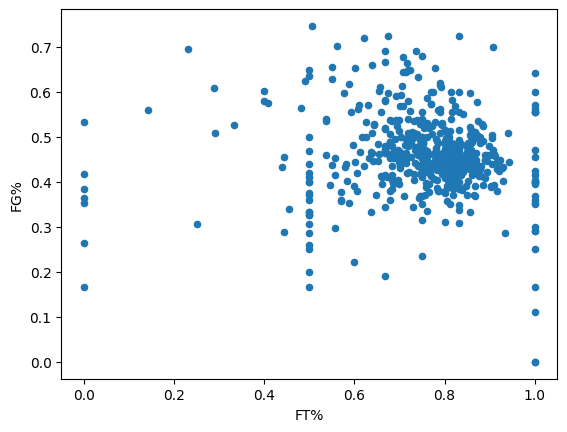

In [4]:
basketball.plot.scatter('FT%','FG%')

**Task2**:

Make a scatter plot with FT% on the horizontal axis and FG% on the vertical axis. Do this for each each Position in the data set.

Pay special attention to the plots for C and PF.

In [6]:
#this is an array of the basketball positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = basketball.Pos.cat.codes.values

#an array of the strings that represent position
pos_codes = basketball.Pos.cat.categories

#puts coords in a dict, so pymc can read them
bb_coords = {"pos": pos_codes}

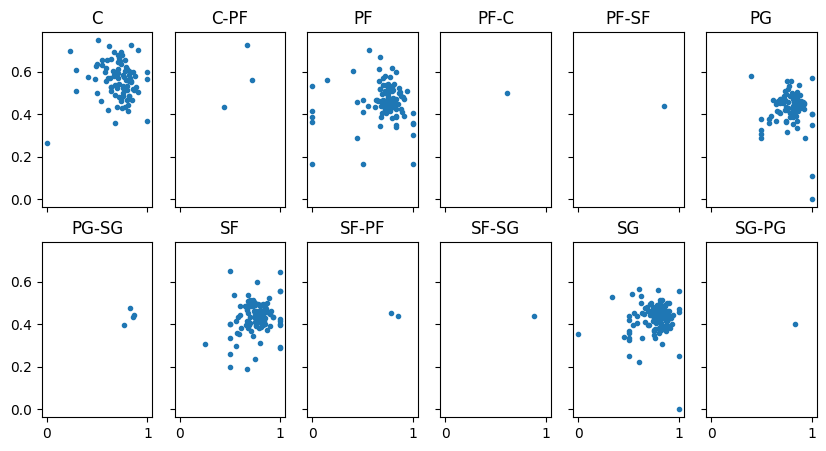

In [7]:
#set up the 12 plots
_, ax = plt.subplots(2, 6, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)

#make a scatter plot for each position
for i, p in enumerate(pos_codes):
    ax[i].scatter(
        x = basketball.query('Pos == @p')['FT%'],
        y =  basketball.query('Pos == @p')['FG%'],
        marker=".")
    ax[i].set_title(f"{p}")

**Task3**:

Originally, I was going to get you to create and run an individual linear regression model for each of the positions.

But I couldn't even get model to run.

Explain why a linear regression model won't run on the full dataset. HInt: look at the graphs you made above, and compare and contrast them to the ones from class.

Or: if you do what I could not and get a linear regression model to run on the full data set, I'll give you full credit and a high five.

- The linear regression model might not work because some of the positions have too few data points for us to be able to get a line we can be reasonably confident in for that position. The large variation throws off the analysis of the entire data set????

## From Linear Model to Generalized Linear Model

You'll now fit a linear regression on the height and weight for people or the Kalahari !Kung San people. Height will be the predictor and weight will be the predicted.

Here's the raw data.

In [61]:
#downloads the data from my github
howell = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/howell.csv')

In [54]:
howell

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


**Task4**:

Make a scatter plot of height versus weight for the howell data set.

<Axes: xlabel='height', ylabel='weight'>

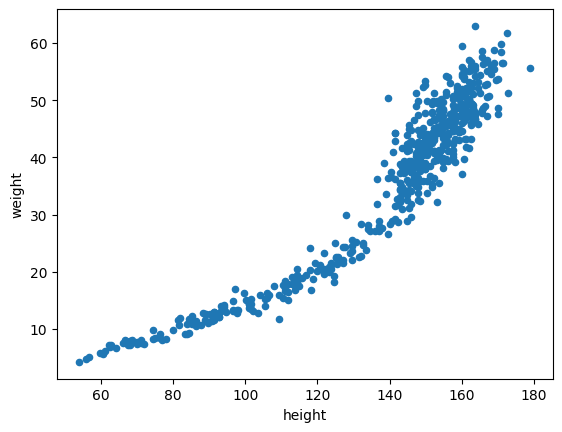

In [55]:
howell.plot.scatter('height', 'weight')

**Task5**:

Create and run a stright line linear regression model on the howell data set with height predicting weight. Visualize your model and its posterior.

In [56]:
with pm.Model() as model_howell:
  α = pm.Normal("α", mu = 0, sigma = 100)
  β = pm.Normal("β", mu = 0, sigma = 10)
  μ = pm.Deterministic("μ", α + β * howell.height)
  σ = pm.HalfCauchy("σ", 10)
  y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed = howell.weight)
  idata_howell = pm.sample()

Output()

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

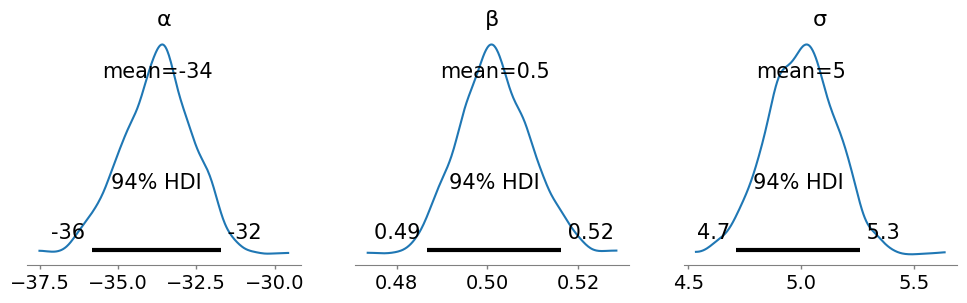

In [57]:
az.plot_posterior(idata_howell, var_names=["~μ"], figsize=(12, 3))

**Task6**:

Run a posterior predictive check for model_howell, plot the posterior predictive distribution, and comment on the fit of the model you made in Task5.

- I think it's alright. From the second ppc, I can tell that it doesn't model the observed data as closely as I would like as it's a little higher and doesn't model the second smaller bump well, but it has the general shape (kind of...).  

In [58]:
pm.sample_posterior_predictive(idata_howell, model=model_howell,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'weight')

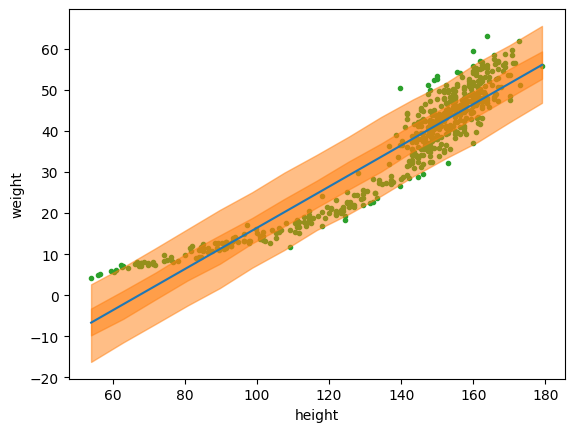

In [62]:
mean_line = idata_howell.posterior["μ"].mean(("chain","draw"))

height = np.random.normal(howell.height.values, 0.01)
idx = np.argsort(height)
x = np.linspace(height.min(), height.max(),15)

y_pred_q = idata_howell.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(height[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_,ax = plt.subplots()
ax.plot(howell.height, howell.weight, "C2.", zorder=-3)
ax.plot(howell.height[idx], mean_line[idx], c="C0")

for howell, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, howell, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("height")
ax.set_ylabel("weight")

<Axes: xlabel='y_pred'>

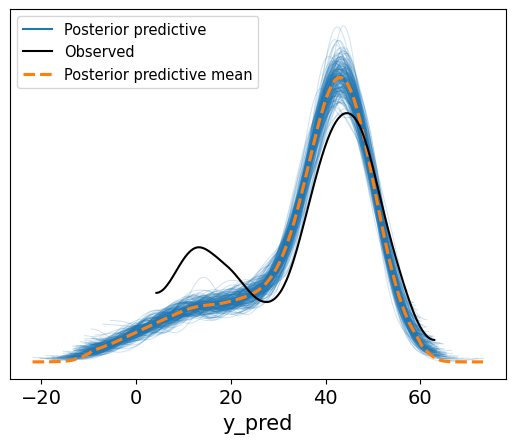

In [63]:
az.plot_ppc(idata_howell, num_pp_samples=200)

**Task7**:

Create and visualize the posterior of a generalized linear model that improves the on the fit of the model you made in Task5.

In [77]:
howell = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/howell.csv')

In [81]:
with pm.Model() as model_howell2:
  α2 = pm.Normal("α2", mu = 0, sigma = 100)
  β2 = pm.Normal("β2", mu = 0, sigma = 10)
  μ2 = pm.Deterministic("μ2", pm.math.exp(α2 + β2 * howell.height))
  σ2 = pm.HalfCauchy("σ2", 10)
  y_pred2 = pm.Normal("y_pred2", mu=μ2, sigma=σ2, observed = howell.weight)
  idata_howell2 = pm.sample()

Output()

array([[<Axes: title={'center': 'α2'}>, <Axes: title={'center': 'β2'}>,
        <Axes: title={'center': 'μ2\n0'}>,
        <Axes: title={'center': 'μ2\n1'}>],
       [<Axes: title={'center': 'μ2\n2'}>,
        <Axes: title={'center': 'μ2\n3'}>,
        <Axes: title={'center': 'μ2\n4'}>,
        <Axes: title={'center': 'μ2\n5'}>],
       [<Axes: title={'center': 'μ2\n6'}>,
        <Axes: title={'center': 'μ2\n7'}>,
        <Axes: title={'center': 'μ2\n8'}>,
        <Axes: title={'center': 'μ2\n9'}>],
       [<Axes: title={'center': 'μ2\n10'}>,
        <Axes: title={'center': 'μ2\n11'}>,
        <Axes: title={'center': 'μ2\n12'}>,
        <Axes: title={'center': 'μ2\n13'}>],
       [<Axes: title={'center': 'μ2\n14'}>,
        <Axes: title={'center': 'μ2\n15'}>,
        <Axes: title={'center': 'μ2\n16'}>,
        <Axes: title={'center': 'μ2\n17'}>],
       [<Axes: title={'center': 'μ2\n18'}>,
        <Axes: title={'center': 'μ2\n19'}>,
        <Axes: title={'center': 'μ2\n20'}>,
        <

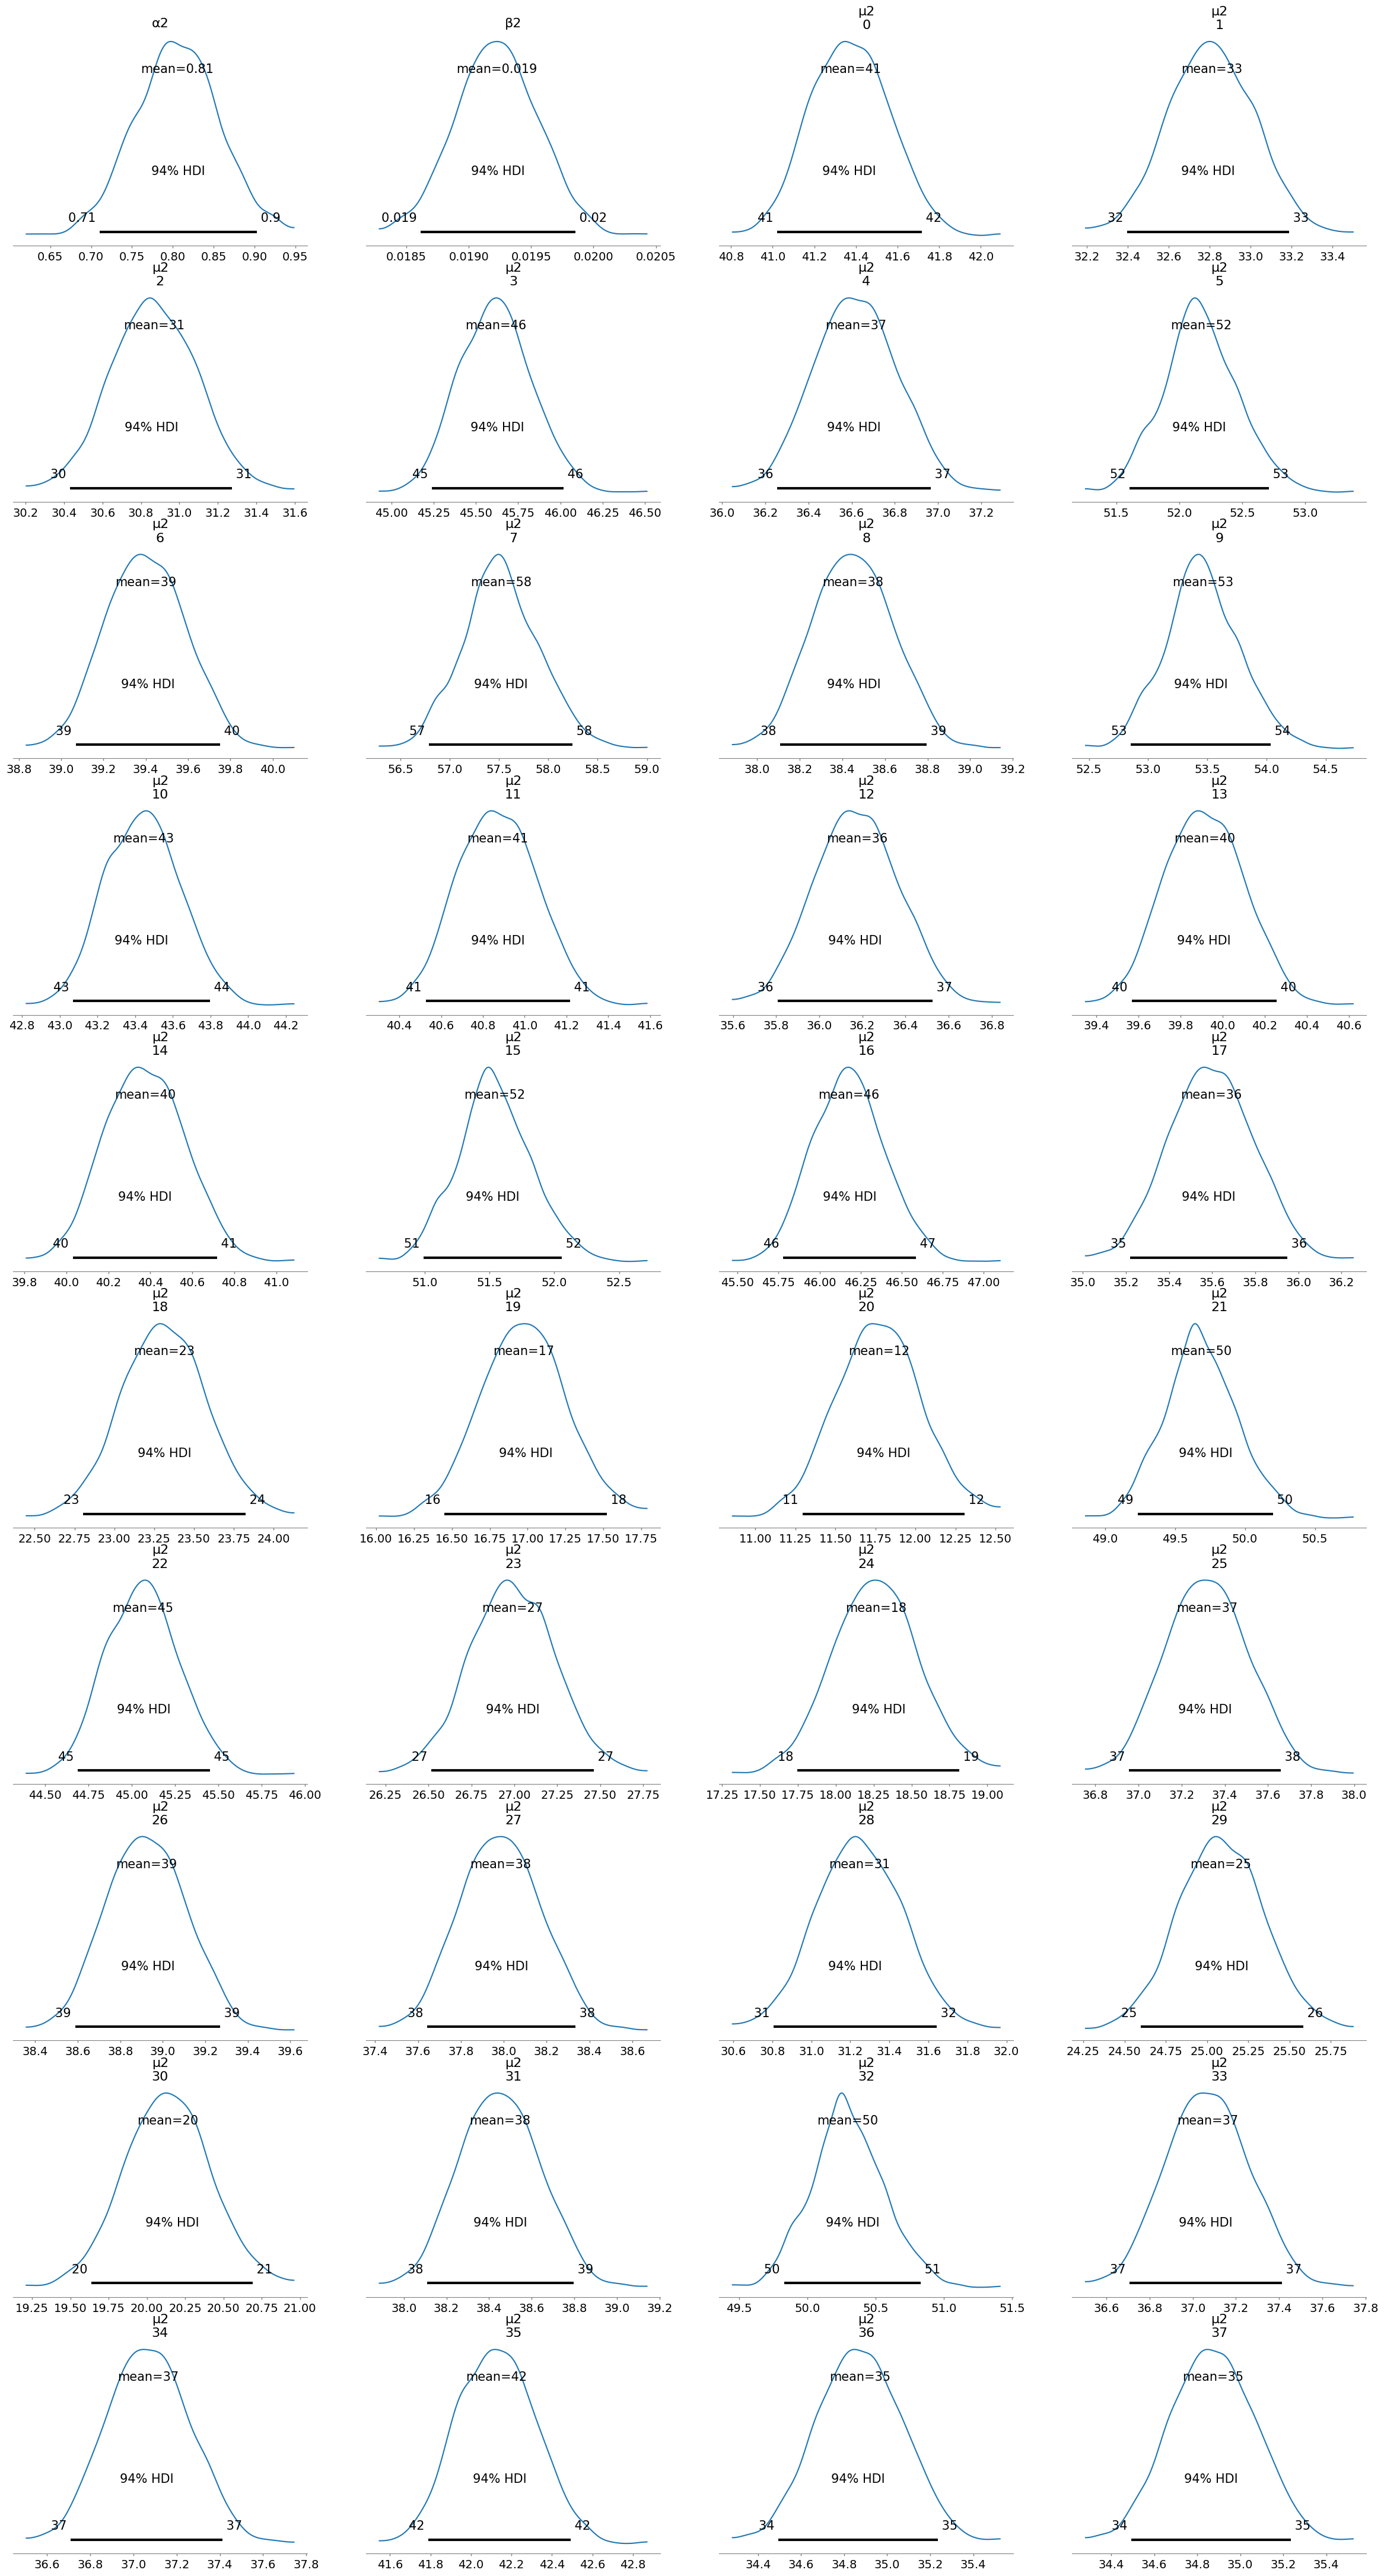

In [72]:
az.plot_posterior(idata_howell2, var_names=["~μ"])

**Task8**:

Run a posterior predictive check, and visualize the posterior predictive distribution, for the model you made in Task7.

Comment on the fit.

In [82]:
pm.sample_posterior_predictive(idata_howell2, model=model_howell2, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'weight')

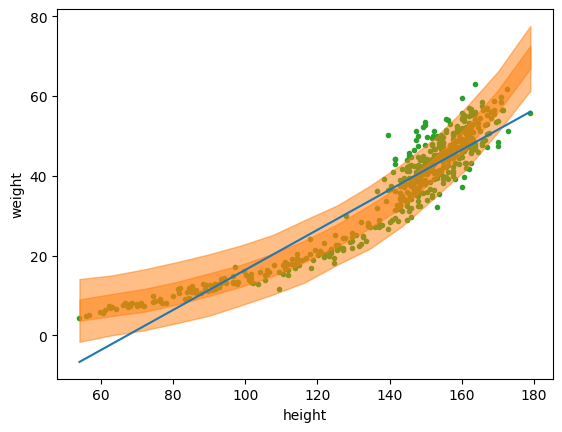

In [85]:
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line2 = idata_howell2.posterior["μ2"].mean(("chain", "draw"))

#creates some x values to run through our line formula
height2 = np.random.normal(howell.height.values, 0.01)
idx2 = np.argsort(height)
x2 = np.linspace(height.min(), height.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q2 = idata_howell2.posterior_predictive["y_pred2"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds2 = iter(
    [
        PchipInterpolator(height[idx2], y_pred_q2[i][idx2])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_2, ax2 = plt.subplots()
ax2.plot(howell.height, howell.weight, "C2.", zorder=-3)
ax2.plot(howell.height[idx2], mean_line[idx2], c="C0")


#graphs the 94% and 50% HDIs
for howell2, ub2 in zip(y_hat_bounds2, y_hat_bounds2):
    ax2.fill_between(x2, howell2, ub2, color="C1", alpha=0.5)

#labels
ax2.set_xlabel("height")
ax2.set_ylabel("weight")